Connected to intership (Python 3.12.9)

c:\Users\kalog\anaconda3\envs\intership\Lib\site-packages\torch\utils\_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
c:\Users\kalog\anaconda3\envs\intership\Lib\site-packages\torch\utils\_cxx_pytree.py:235: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFBoxParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(


cpu
Testing the dataset's size sample torch.Size([1, 16, 16])
Epoch 1/10 - Loss: 0.6855 - Accuracy: 50.5556 %
Epoch 2/10 - Loss: 0.5916 - Accuracy: 57.6389 %
Epoch 3/10 - Loss: 0.2578 - Accuracy: 81.9444 %
Epoch 4/10 - Loss: 0.1561 - Accuracy: 89.1667 %
Epoch 5/10 - Loss: 0.0920 - Accuracy: 93.1944 %
Epoch 6/10 - Loss: 0.0647 - Accuracy: 95.1389 %
Epoch 7/10 - Loss: 0.0508 - Accuracy: 96.3889 %
Epoch 8/10 - Loss: 0.0437 - Accuracy: 97.0833 %
Epoch 9/10 - Loss: 0.0355 - Accuracy: 97.9167 %
Epoch 10/10 - Loss: 0.0290 - Accuracy: 98.3333 %


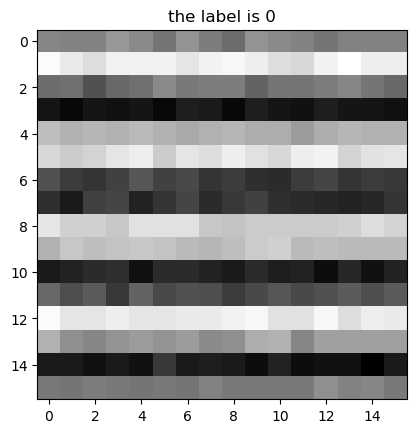

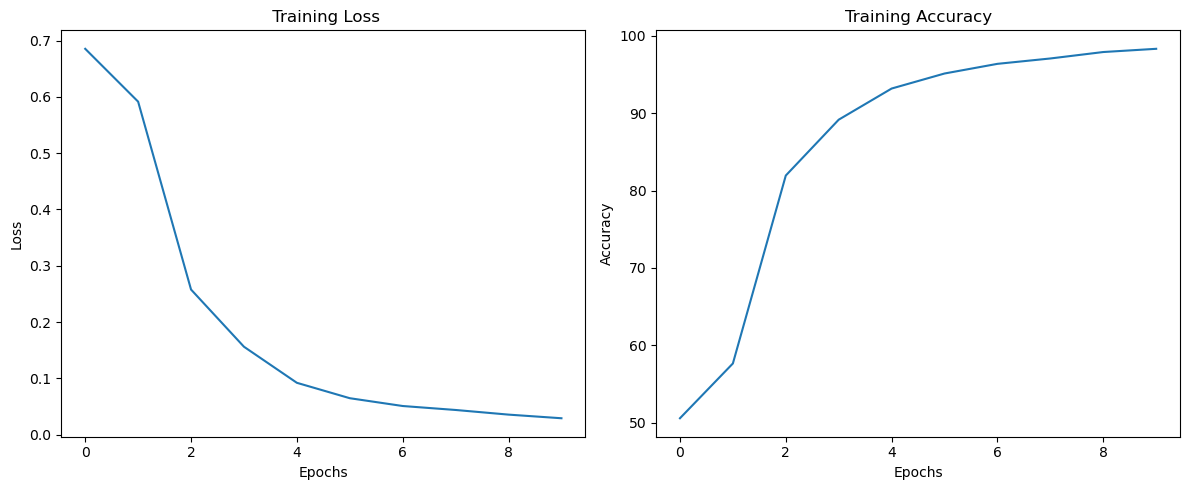

Test loss is : 0.0470 
 Accurace is : 95.67 %


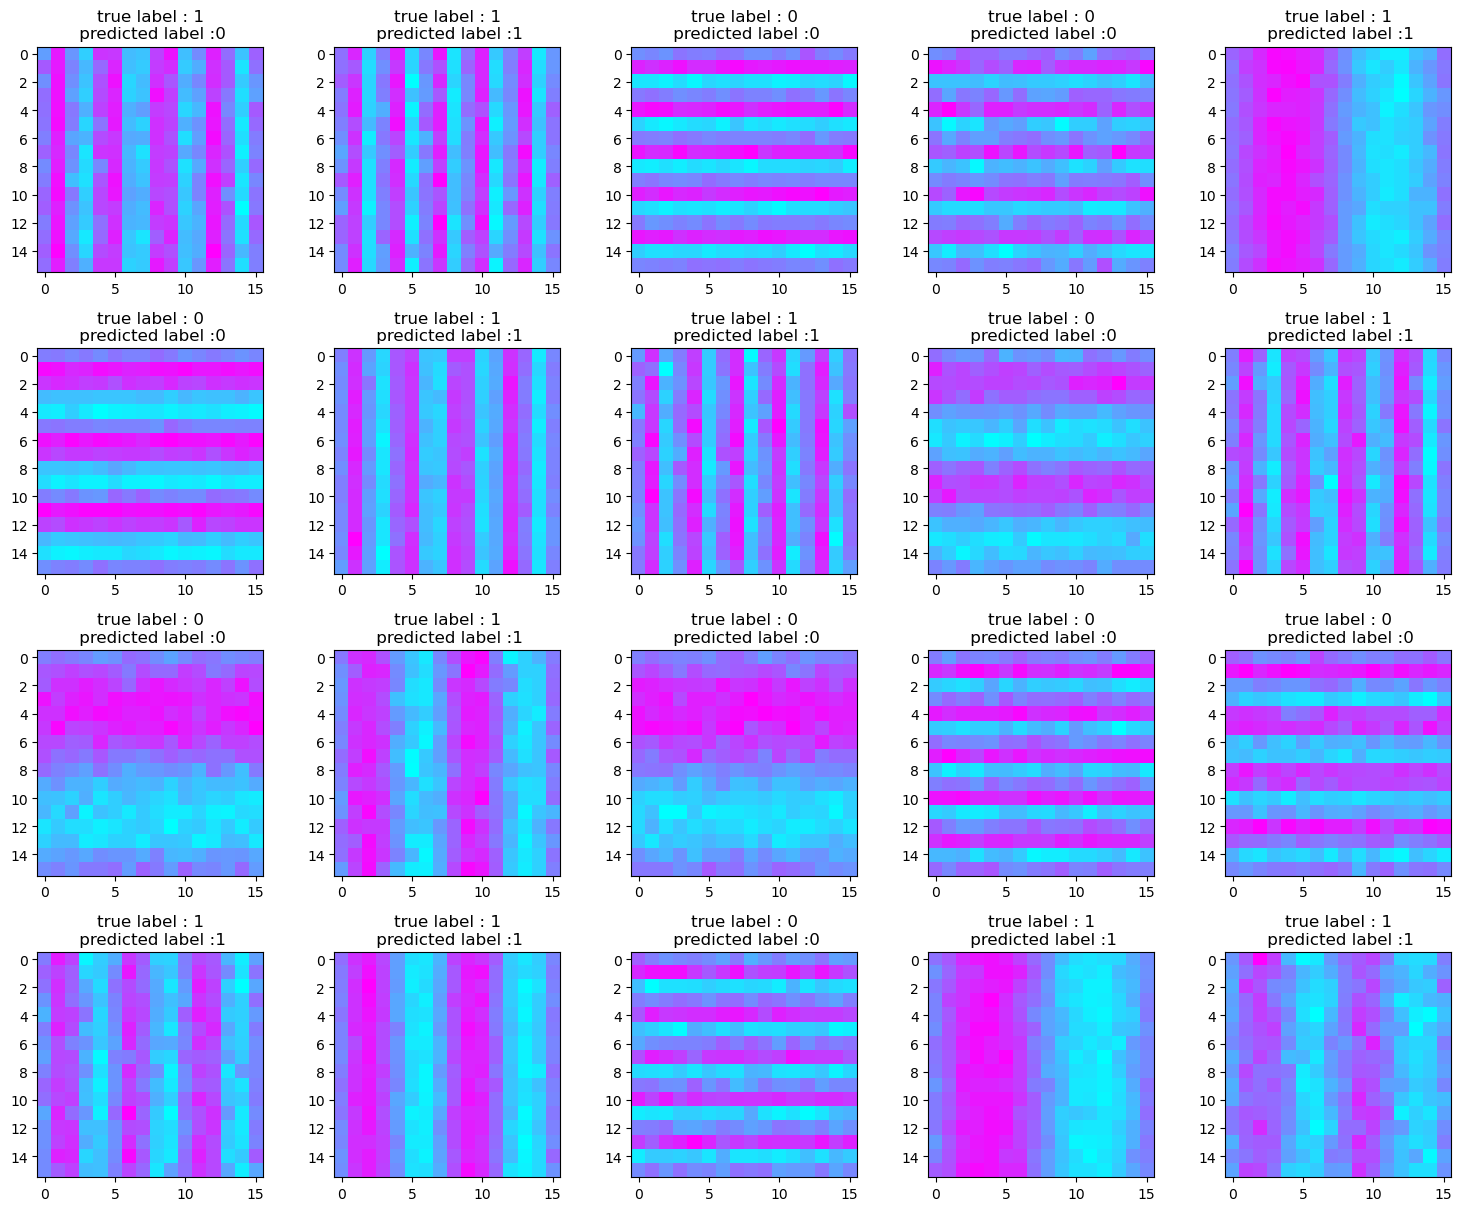

In [ ]:
import numpy as np
import norse.torch as norse
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from class_dataset import CustomSinDataset
import torch.utils.data.dataloader
from norse.torch.functional.encode import constant_current_lif_encode  # rate encoding
from torch.utils.data import random_split

# TODO implement custom learning rate approach
# TODO perhaps implement custom LIF parameters

#! THE BEST ONE FOR NOW IS n_steps = 300 and lr= 0.009 // 88%
#! INITIALIZE THE DEVICE

# we remove the threshhold
torch.set_printoptions(threshold=float("inf"))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

#! HYPERPARAMETERS
input_size = 256  # 16*16
# hidden_size = ?
num_classes = 2
epochs = 10
prcnt_of_train = 0.7
batch_size = 30
learning_rate = 0.01
num_steps = 320
v_threshold = torch.tensor([0.8])

#! TRANSFORM
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Grayscale(),
        # transforms.Normalize((0.5,), (0.5,)),
    ]
)

dataset = CustomSinDataset(root="./custom_dataset", transform=transform)

#! SPLIT THE DATA TO TRAIN AND TEST
train_size = int(len(dataset) * prcnt_of_train)
test_size = len(dataset) - train_size
test_size
train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

sample_data, sample_label = train_dataset[0]
sample_label
sample_data
plt.title(f"the label is {sample_label}")
plt.imshow(sample_data[0], cmap="cool")
print(f"Testing the dataset's size sample {sample_data.size()}")

#! DEFINE THE DATA LOADER

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)


#! DEFINING AND CREATING THE MODEL
class SimpleSNN(nn.Module):
    def __init__(self, input_size, output_size, num_steps):
        super(SimpleSNN, self).__init__()

        self.num_steps = num_steps

        #! DEFINE THE LAYERS (SIMPLE THOUGH)
        # Convolutional layer
        self.conv = nn.Conv2d(1, 2, 4, 1)
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        # Flatten where the new size is 13x13 cause of the kernel 4 convolution
        self.flatten_size = 2 * 6 * 6
        # Linear layer to map the flattened features to output classes
        self.linear = nn.Linear(self.flatten_size, output_size)
        # Single LIF layer for the spikes
        self.lif = norse.LIFCell(p=norse.LIFParameters())

    def forward(self, x):
        batch_size = x.shape[0]  # current batch size cause [B,C,H,W]

        # I also scaled the input tensor because the original tensor had smaller values 
        x_encoded = constant_current_lif_encode(
            x*10, p=norse.LIFParameters(), seq_length=self.num_steps
        )  # now the shpae is [time,b,c,h,w]

        # print(x_encoded)
        counter = 0
        mem_state = None
        mem_record = []
        spk_record = []

        for step in range(self.num_steps):
            xt = x_encoded[step]  # gives the [b,c,h,w]

            conv_out = self.conv(xt)
            pooled = self.pool(conv_out)
            flat = pooled.view(batch_size, -1)
            linear_out = self.linear(flat)
            spk, mem_state = self.lif(linear_out, mem_state)

            if step % 20 == 0 :
                counter +=1
                # print(f"prints the encoded input every 20 steps {xt} for step{20*counter}")
                # print(f"This is the spk value {spk_record} for step {counter*20}")
                # print(f"This is the membrance voltage {mem_state.v} for step {counter*20}")
            spk_record.append(spk)
            mem_record.append(mem_state.v)

        spk_out = torch.stack(spk_record, dim=0).sum(0)

        return spk_out, mem_record


#! CREATE THE MODEL
model = SimpleSNN(input_size=input_size, output_size=num_classes, num_steps=num_steps)

#! LOSS FUNCTION
criterion = nn.CrossEntropyLoss()

#! OPTIMIZER
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)


#! DEFINING THE TRAIN IN THE MODEL
def train(model, train_loader, optimizer, criterion, num_steps, epochs):
    loss_history = []
    acc_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_acc = 0
        num_batches = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # if i == 0 and epoch % 2 == 0:
            #     print(f"Input shape: {inputs.shape}, Labels: {labels}")
            #     print(f"Input min: {inputs.min()}, max: {inputs.max()}")
            model.train()
            spk_out, mem_record = model(inputs)

            loss = torch.zeros((1), device=device)

            loss = criterion(spk_out, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = spk_out.argmax(dim=1)
            acc = (preds == labels).float().mean() * 100

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            num_batches += 1

            # print(f"batch = {i + 1}:")
            # print(f"inputs shape: {inputs.shape}")
            # print(f"spikek output: {spk_out}")
            # print(f"preds: {preds}")
            # print(f"labels: {labels}")
            # print(f"batch loss: {loss.item():.4f}, \nbatch accuracy: {acc.item():.2f}%")

        avg_epoch_loss = epoch_loss / num_batches
        avg_epoch_acc = epoch_acc / num_batches

        loss_history.append(avg_epoch_loss)
        acc_history.append(avg_epoch_acc)

        print(
            f"Epoch {epoch + 1}/{epochs} - Loss: {(avg_epoch_loss):.4f} - Accuracy: {avg_epoch_acc:.4f} %"
        )

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history)
    plt.title(" Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(acc_history)
    plt.title("Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.tight_layout()
    plt.show()


#! DEFINE THE TESTING
def test(model, test_loader, num_steps):
    correct = 0
    loss = 0
    accuracy = 0
    total = 0

    # for plotting
    imgs_to_plot = []
    true_labels = []
    pred_labels = []

    # Disables gradient calculation
    with torch.no_grad():
        model.eval()

        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            test_spk, test_mem = model(data)

            _, predicted = test_spk.max(1)  # we obtain the predicted spike values

            total += labels.size(0)
            correct = correct + (predicted == labels).sum().item()

            loss += (
                criterion(test_spk, labels).item()
            )  # update the loss based on the last value ofthe spiking membrance voltage

            # Save 2 images from each batch to plot and see the prediction
            for i in range(min(2, data.size(0))):
                img = data[i].squeeze().numpy()
                imgs_to_plot.append(img)  # we remove the 1 greyscale channel
                true_labels.append(labels[i].item())
                pred_labels.append(predicted[i].item())

    avg_loss = loss / len(test_loader)
    accuracy = 100 * (correct / total)

    print(f"Test loss is : {(avg_loss):.4f} \n Accurace is : {(accuracy):.2f} %")

    # we are going to plot the images with the true labels and the predicted ones
    num_images = len(imgs_to_plot)
    columns = 5
    rows = round((num_images + columns) // columns)

    plt.figure(figsize=(15, rows * 3))

    for idx, img in enumerate(imgs_to_plot):
        plt.subplot(rows, columns, idx + 1)
        plt.imshow(img, cmap="cool")
        plt.title(
            f"true label : {true_labels[idx]}\n predicted label :{pred_labels[idx]}"
        )
        plt.tight_layout()
    plt.show()


#! TRAIN THE MODEL
train(model, train_loader, optimizer, criterion, num_steps, epochs)

#!TEST THE MODEL
test(model, test_loader, num_steps)